The raw OECD Better Life Index dataset was obtained from
https://stats.oecd.org/Index.aspx?DataSetCode=BLI

The Better Life Index aims to involve citizens in the debate on measuring the well-being of societies, and to empower them to become more informed and engaged in the policy-making process that shapes all our lives.

Brief recap of data, goals, tasks.
I'm using the data from OECD's Better Life Index. It provides 20 quality of life indicators for 42 countries. Please note that I removed some of the indicators as part of the data wrangling.
I tried to create an interactive visualisation where the end user would be able to look at different indicators and see if they are correlated with each other. Using the visualisation, the user can select 3 indicators - one for each dimension - x-axis, y-axis and the colour of the mark.
The user selects 3 indicators using the dropdown widgets and the chart updates accordingly.

I wasn't sure how to retain the chart's interactivity when saving as an HTML, so here are some screenshots:
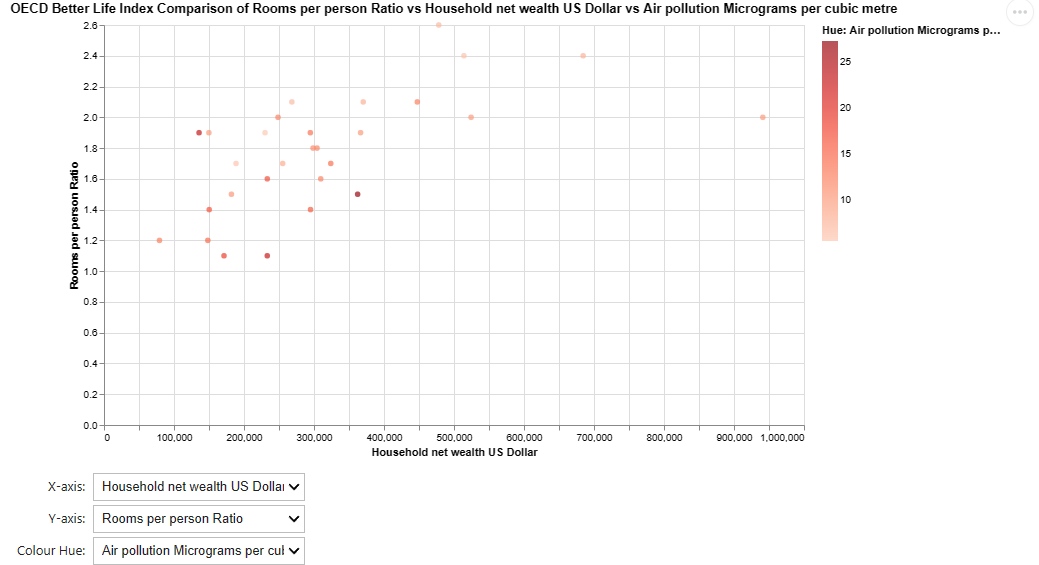

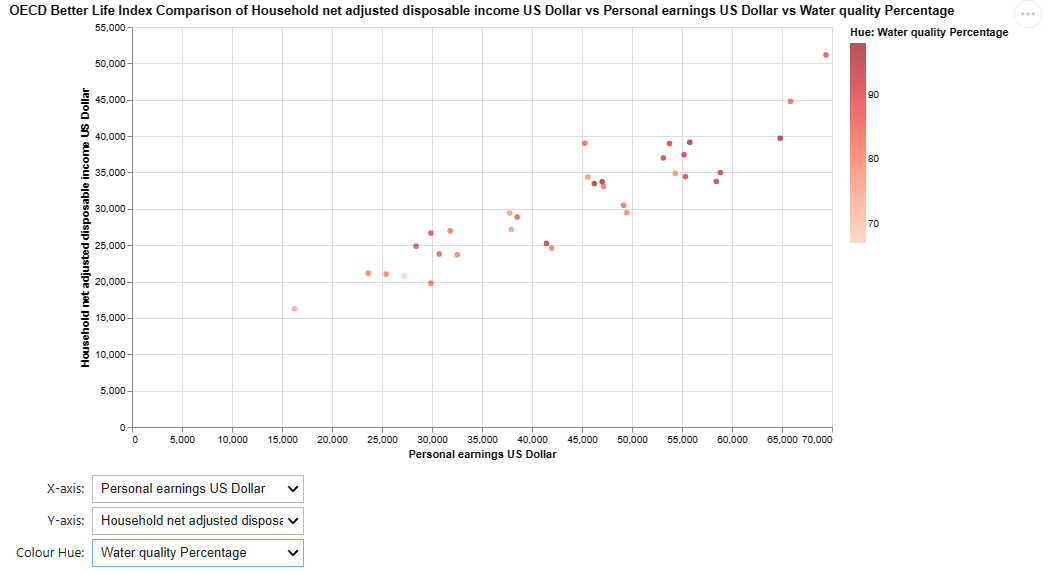

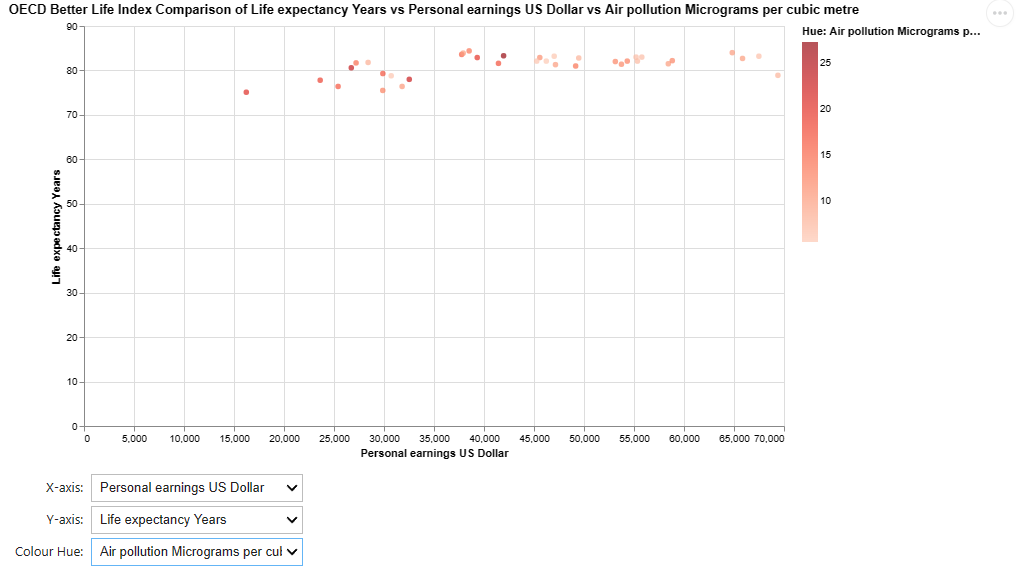

Summary of the key elements of the design
This is an X and Y axis chart. I chose this so that it would be easier to notice correlated indicators. I'm using 3 dropdown widgets so the user is able to select indicators of interest. Hovering over each datapoint gives the information about that datapoint - the name of the country and the values for the 3 respective indicators (x, y and hue). 




Reading in data, cleaning it up and transforming it into wide format

In [38]:
# reading in data
data_long = pd.read_csv("OECD_Better_Life_Index_Stripped.csv")


# To simplify analysis, let's only leave rows that have Total in the Inequality column. For simplicity, not breaking down data by gender.
data_filtered_1 = data_long[data_long['Inequality'] == 'Total']

# Now let's get rid of the Inequality column
data_filtered_2 = data_filtered_1.drop(columns=['Inequality'])

# Now let's pivot the table to a wide table
data_wide = data_filtered_2.pivot_table(
    index='Country', 
    columns=['Indicator', 'Unit'], 
    values='Value'
).reset_index()

# Removing columns that we will not include in the analysis because they are a little too vague
data_wide = data_wide.drop(columns='Self-reported health', level='Indicator')
data_wide = data_wide.drop(columns='Stakeholder engagement for developing regulations', level='Indicator')
data_wide = data_wide.drop(columns='Time devoted to leisure and personal care', level='Indicator')
data_wide = data_wide.drop(columns='Quality of support network', level='Indicator')
#data_wide.head()
data_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   (Country, )                                            42 non-null     object 
 1   (Air pollution, Micrograms per cubic metre)            42 non-null     float64
 2   (Dwellings without basic facilities, Percentage)       39 non-null     float64
 3   (Educational attainment, Percentage)                   41 non-null     float64
 4   (Employees working very long hours, Percentage)        40 non-null     float64
 5   (Employment rate, Percentage)                          42 non-null     float64
 6   (Feeling safe walking alone at night, Percentage)      42 non-null     float64
 7   (Homicide rate, Ratio)                                 42 non-null     float64
 8   (Household net adjusted disposable income, US Dollar

In [39]:
import ipywidgets as widgets
from IPython.display import display
import altair as alt
import pandas as pd

# Getting each indicator
indicators = [col for col in data.columns if 'Country' not in col]

# Creating three dropdown widgets for the x-axis, y-axis and hue (z-axis) indicator selections
dropdown_x = widgets.Dropdown(
    options=indicators,
    value=indicators[0],  # default value
    description='X-axis:',
)

dropdown_y = widgets.Dropdown(
    options=indicators,
    value=indicators[1],  # default value, ensure it's different from x-axis
    description='Y-axis:'
)

dropdown_z = widgets.Dropdown(
    options=indicators,
    value=indicators[2], # default value to ensure it is different from the other 2 axis
    description='Colour Hue:'
)

# Function to create the chart based on selected indicators
def create_chart(x_indicator, y_indicator, z_indicator):
    chart = alt.Chart(data).mark_circle().encode(
        x=alt.X(x_indicator, type='quantitative', title=x_indicator),
        y=alt.Y(y_indicator, type='quantitative', title=y_indicator),
        color=alt.Color(z_indicator, type='quantitative', title=z_indicator, 
                        scale=alt.Scale(scheme='reds'),  # Maybe there could be a better color scheme for display ordinal data...
                        legend=alt.Legend(title="Hue: " + z_indicator)),
        tooltip=['Country:N', alt.Tooltip(x_indicator), alt.Tooltip(y_indicator), alt.Tooltip(z_indicator)]
    ).properties(
        width=700,
        height=400,
        title=f"OECD Better Life Index Comparison of {y_indicator} vs {x_indicator} vs {z_indicator}"
    )
    return chart

# Initially displaying the chart with the default (first 3) indicators
current_chart = create_chart(dropdown_x.value, dropdown_y.value, dropdown_z.value)

# Function to update the chart, this function is called every time any dropdown's value changes
def update_chart(change):
    # Clear the previous chart
    display_container.clear_output(wait=True)
    # Create a new chart with the new indicators
    new_chart = create_chart(dropdown_x.value, dropdown_y.value, dropdown_z.value)
    # Display the new chart
    with display_container:
        display(new_chart)

# Observing changes in the dropdown values
dropdown_x.observe(update_chart, names='value')
dropdown_y.observe(update_chart, names='value')
dropdown_z.observe(update_chart, names='value')

# Creating a container for displaying the chart
display_container = widgets.Output()
with display_container:
    display(current_chart)

# Arrange the dropdowns and chart vertically
widgets.VBox([display_container, dropdown_x, dropdown_y, dropdown_z])
